In [ ]:
import pandas as pd
import numpy as np
# import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from datetime import datetime
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='default')
import os

In [30]:
sm_site_list = pd.read_csv('/mnt/d/ubuntu/projects/gatechProjects/StochSM/data/gages/ARS_data/SF_stations_.csv')

fn_format = '/mnt/d/ubuntu/projects/gatechProjects/StochSM/data/gages/ARS_data/1607.zip/SMAP/{st_id}_20130101.csv'
# #
header_list = ['ID','Yr','Mo','Day','Hr','Min','TOY','Tair','PREC_1','PREC_2','SM_5','ST_5','SM_10','ST_10','SM_20','ST_20','SM_50','ST_50']
dtypes = 6*['string'] + 12*['float']
dtype_dict = dict()
for i,col in enumerate(header_list):
    dtype_dict[col] = dtypes[i]
sf_gages = dict()

for st_id in sm_site_list['Site ID'][0:20]:
    st_id = str(st_id)
    fn = fn_format.format(st_id=st_id)
    sf_gages[st_id] = pd.read_csv(fn, index_col=False, skiprows=2)
    sf_gages[st_id].columns = header_list
    sf_gages[st_id] = sf_gages[st_id].astype(dtype_dict)
    sf_gages[st_id] = sf_gages[st_id].replace([-99, -88], np.nan)
    dt = sf_gages[st_id]['Yr'] + '-' + sf_gages[st_id]['Mo'] + '-' + sf_gages[st_id]['Day'] + ' ' + sf_gages[st_id]['Hr'] + ':0' + sf_gages[st_id]['Min']
    sf_gages[st_id]['date'] = pd.to_datetime(dt)
    sf_gages[st_id]['date'] = sf_gages[st_id]['date'] + pd.DateOffset(hours=5)



In [25]:
out_columns = ['date', 'PREC_1','PREC_2', 'SM_5', 'ST_5', 'SM_10','ST_10','SM_20','ST_20','SM_50','ST_50']
out_fn_format = '/mnt/d/ubuntu/projects/gatechProjects/StochSM/data/hydrovise_data/ars/{year}/{st_id}.csv'
for st_id in sm_site_list['Site ID'][0:20]:
    for year in range(2013,2021):
        idx = sf_gages[str(st_id)]['date'].dt.year == year
        subset = sf_gages[str(st_id)].loc[idx]
        fn_out = out_fn_format.format(year = str(year), st_id= st_id)
        [out_path, _]  = os.path.split(fn_out)
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        if len(~subset['PREC_1'].isna())/len(subset) > 0.1:
            subset[out_columns].to_csv(fn_out,index=False, date_format='%Y-%m-%d %H:%M')

## Process GPM data 
## convert to hourly data

In [ ]:
gage_gpm_fmt = '/mnt/d/ubuntu/projects/gatechProjects/StochSM/data/GPM/ars/fid_{fid}.csv'
gpm_gage = dict()
for fid in range(20):
    fid = str(fid)
    _data = pd.read_csv(gage_gpm_fmt.format(fid=fid), index_col=None)
    _data['date'] = pd.to_datetime(_data['date'])
    x = _data.set_index('date')
    gpm_gage[fid] = x['value'].resample('H').sum()/2
    gpm_gage[fid] = gpm_gage[fid].reset_index()

In [ ]:
lut_gpm_gage = pd.read_csv('/mnt/d/ubuntu/projects/gatechProjects/StochSM/data/GPM/lut_gage_gpm_v1.csv')

In [ ]:
lut_gpm_gage

In [ ]:
gage_p_sum = []
for i, st_id in enumerate(lut_gpm_gage['st_id']):
    fid = str(lut_gpm_gage['FID'][i])
    st_id = str(st_id)
    gage_p_sum.append((st_id, np.nansum(sf_gages[st_id]['PREC_1']), np.nansum(sf_gages[st_id]['PREC_2']), np.nansum(gpm_gage[fid]['value'])))

gage_p_sum = pd.DataFrame(gage_p_sum, columns=['st_id', 'sum_PREC_1','sum_PREC_2', 'sum_GPM'])

In [31]:
gage_p_sum_matched = []
gage_gpm_matched = dict()
for i, st_id in enumerate(lut_gpm_gage['st_id']):
    fid = str(lut_gpm_gage['FID'][i])
    st_id = str(st_id)
    # gpm_gage_ = gpm_gage[fid].set_index('date')
    # sf_gages_ = sf_gages[st_id].set_index('date')
    gpm_gage_ = gpm_gage[fid]#.set_index('date')
    sf_gages_ = sf_gages[st_id]#.set_index('date')
    gage_gpm_matched[st_id] = pd.merge(gpm_gage_, sf_gages_)
#     gage_p_sum.append((st_id, np.nansum(sf_gages[st_id]['PREC_1']), np.nansum(sf_gages[st_id]['PREC_2']), np.nansum(gpm_gage[fid]['value'])))

# gage_p_sum = pd.DataFrame(gage_p_sum, columns=['st_id', 'sum_PREC_1','sum_PREC_2', 'sum_GPM'])

In [ ]:

fig,ax = plt.subplots(10,2,figsize=(15,10),sharex=True)
for i, st_id in enumerate(lut_gpm_gage['st_id']):
    st_id = str(st_id)
    i_col = i%2
    i_row = int(i/2)
    ax[i_row,i_col].plot(gage_gpm_matched[st_id]['date'],gage_gpm_matched[st_id]['value'])
    ax[i_row,i_col].plot(gage_gpm_matched[st_id]['date'],gage_gpm_matched[st_id]['PREC_1'])
    ax[i_row,i_col].plot(gage_gpm_matched[st_id]['date'],gage_gpm_matched[st_id]['PREC_2'])

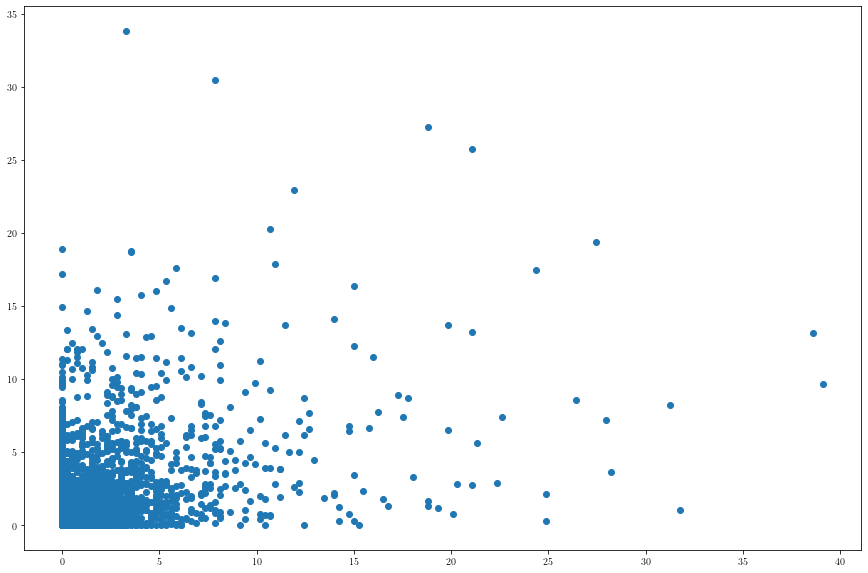